# A Fail-Safe Maximum Criticality Policy

In [1]:
import numpy as np

from domoku.tools import GomokuTools as Gt
from domoku.data import create_binary_rep
from domoku.board import GomokuBoard
from domoku.policies import maximal_criticality as mc

import tensorflow as tf

## Constant filters

We provide a factory class that creates initializers for various convolutional filters to be used in policies. Note that this is different from detectors that identify the mere existence.

Our filters identify the field that exploits the pattern.

In [15]:
INPUT_SIZE = 9

In [16]:
policy = mc.MaxCriticalityPolicy(INPUT_SIZE)
patterns = policy.select_patterns()
len(patterns)

/Users/wgiersche/.local/share/virtualenvs/DeepGomoku-cXtJ_EtM/lib/python3.10/site-packages/numpy/core/fromnumeric.py:2007: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = asarray(a).shape


60

In [17]:
filters, _, _ = policy.assemble_primary_filters()

4 symmetries for each pattern

In [18]:
filters.shape

(11, 11, 3, 240)

In [19]:
print(filters[:, :, 0, 0])

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


This is a rotation-invariant filter set that represents a particular pattern '...XX.XX...' anywhere on the board

In [20]:
filters, biases, weights = policy.assemble_primary_filters()

In [21]:
index = 4
Gt.print_bin(filters[:, :, :, index])
print(weights[index])
print(biases[index])

shape: (11, 11, 3)
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
500
-4


## MaxCriticalityPolicy

This policy will always propose the field with highest criticality

### Test it on a real board

In [22]:
INPUT_SIZE=7
policy = mc.MaxCriticalityPolicy(INPUT_SIZE)

/Users/wgiersche/.local/share/virtualenvs/DeepGomoku-cXtJ_EtM/lib/python3.10/site-packages/numpy/core/fromnumeric.py:2007: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = asarray(a).shape


In [23]:
def suggest_greedy(sample):
    res = policy(sample)
    vec = tf.reshape(res, (1, -1))
    pos = tf.squeeze(tf.argmax(vec, axis=1))
    print(pos)
    r = pos // (INPUT_SIZE + 2)
    c = pos - r * (INPUT_SIZE + 2)
    bx, by = Gt.m2b((r-1, c-1), size=INPUT_SIZE)
    return chr(64 + bx) + str(by)

In [24]:
samples = {
    'b1c5d3e3e4f2c3d4': 'B6',
    'b1c5d3e3e4f2c2d5': 'F5',
}
examine = 'b1c5d3e3e4f2c3d4'

#### Verify the policy output

In [25]:
from alphazero.gomoku_board import Board
board = Board(7, 'b1c5d3e3e4f2c3d4')

In [26]:
board.plot(x_is_next=True)

                             
 7    .  .  .  .  .  .  .    
 6    .  .  .  .  .  .  .    
 5    .  .  0  .  .  .  .    
 4    .  .  .  0  X  .  .    
 3    .  .  X  X  0  .  .    
 2    .  .  .  .  .  0  .    
 1    .  X  .  .  .  .  .    
                             
      A  B  C  D  E  F  G


In [27]:
print(np.squeeze(policy(board.math_rep)))

[[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0. 50.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  1.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0. 50.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.]]


In [28]:
for stones, move in samples.items():
    board = Board(7, stones)
    sample = board.math_rep
    res = policy(sample)
    suggested = suggest_greedy(sample)
    board.act(move)
    assert(move == suggested), f"Oops: expected: {move}, got {suggested}"
    if stones == examine:
        board.plot()
        print(np.squeeze(res.numpy()))
        print(suggested)
print("All good. Congrats!!!")

tf.Tensor(20, shape=(), dtype=int64)
                             
 7    .  .  .  .  .  .  .    
 6    .  X  .  .  .  .  .    
 5    .  .  0  .  .  .  .    
 4    .  .  .  0  X  .  .    
 3    .  .  X  X  0  .  .    
 2    .  .  .  .  .  0  .    
 1    .  X  .  .  .  .  .    
                             
      A  B  C  D  E  F  G
[[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0. 50.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  1.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0. 50.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.]]
B6
tf.Tensor(33, shape=(), dtype=int64)
All good. Congrats!!!


In [32]:
stones = 'c3e3c4e2c5e1'
board = Board(INPUT_SIZE, stones=stones)
sample = board.math_rep.copy()
res = policy(sample)
print(np.squeeze(res.numpy()))
suggested = suggest_greedy(sample)
board.plot()
print(suggested)

[[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0. 10.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  1.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0. 10.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.]]
tf.Tensor(21, shape=(), dtype=int64)
                             
 7    .  .  .  .  .  .  .    
 6    .  .  .  .  .  .  .    
 5    .  .  X  .  .  .  .    
 4    .  .  X  .  .  .  .    
 3    .  .  X  .  0  .  .    
 2    .  .  .  .  0  .  .    
 1    .  .  .  .  0  .  .    
                             
      A  B  C  D  E  F  G
C6


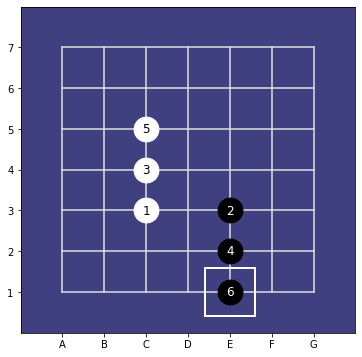

In [33]:
GomokuBoard(7, stones=Gt.string_to_stones(stones)).display()